# Problem Set 1
### Cameron Smith

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Ellipse
import scipy.optimize as op
import emcee
from corner import corner

Load in Data:

In [2]:
_, x, y, y_err, x_err, rho_xy = data = np.array([
    [1,  201, 592, 61,  9, -0.84],
    [2,  244, 401, 25,  4, +0.31],
    [3,   47, 583, 38, 11, +0.64],
    [4,  287, 402, 15,  7, -0.27],
    [5,  203, 495, 21,  5, -0.33],
    [6,   58, 173, 15,  9, +0.67],
    [7,  210, 479, 27,  4, -0.02],
    [8,  202, 504, 14,  4, -0.05],
    [9,  198, 510, 30, 11, -0.84],
    [10, 158, 416, 16,  7, -0.69],
    [11, 165, 393, 14,  5, +0.30],
    [12, 201, 442, 25,  5, -0.46],
    [13, 157, 317, 52,  5, -0.03],
    [14, 131, 311, 16,  6, +0.50],
    [15, 166, 400, 34,  6, +0.73],
    [16, 160, 337, 31,  5, -0.52],
    [17, 186, 423, 42,  9, +0.90],
    [18, 125, 334, 26,  8, +0.40],
    [19, 218, 533, 16,  6, -0.78],
    [20, 146, 344, 22,  5, -0.56],
]).T

## Question 1

We have a model given by:
$$ y_i \sim \mathcal{N}(mx_i+b,\sigma_{y_i}) \quad .$$

i.e. a normal distribution centered at $y_i = m x_i$ with a standard deviation: $\sigma_{y_i}$, for each $i \in \{1, ..., n\} $.

To convert this to matrix form, we first, we define the following matrices

$$
\mathbf{Y} = \left[\begin{array}{c}
            y_{1} \\
            y_{2} \\
            \cdots \\
            y_N \end{array}\right]\\
\mathbf{A} = \left[\begin{array}{cc}
        1 & x_1 \\
        1 & x_2 \\
        1 & \cdots \\
        1 & x_N
        \end{array}\right]\\        
\mathbf{C} = \left[\begin{array}{cccc}
        \sigma_{y1}^2 & 0 & \cdots & 0 \\
        0 & \sigma_{y2}^2 & \cdots & 0 \\
        0 & 0 & \ddots & 0 \\
        0 & 0 & \cdots & \sigma_{yN}^2 
        \end{array}\right] \\        
$$

$$
\mathbf{X} = \left[\begin{array}{c} b \\ m \end{array}\right]
$$

Where, $\mathbf{A}$ is the design matrix and $\mathbf{C}$ is the covariance matrix. Note that based on our model, each point $y_i$ depends only on $\sigma_{y_i}$, i.e. there are no covariences, and therfore no off-diagonal components on the covarience matrix. Our line equation ($y_i = m x_i$) is therefore given by 

$$
        \mathbf{Y} = \mathbf{A}\mathbf{X} \quad .
$$

This is overconstrained however, and so we must weight each datapoint with the covarience matrix:

$$
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
\mathbf{Y} &=& \mathbf{AX} \\
\mathbf{C}^{-1}\mathbf{Y} &=& \mathbf{C}^{-1}\mathbf{AX} \\
\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y} &=& \mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{AX} \\
\left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y}\right] &=& \left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{A}\right]\mathbf{X}
\end{array}
$$

And so the best fit values for $\mathbf{X}$ (i.e. the parameters which maximise the likelihood of the data) are given by:

$$
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\mathbf{X} = \left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{A}\right]^{-1}\left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y}\right] \quad .
$$


This could also be done by maximising the likelihood of the data explicitly. To do this, we introduce the expected frequency distribution, which is given by:

$$p(y_i|x_i,\sigma_{yi},m,b) = \frac{1}{\sqrt{2\pi\sigma_{yi}^2}}\exp\left(-\frac{\left[y_i-mx_i - b\right]^2}{2\sigma_{yi}^2}\right)$$

The total likelihood is then the probability of all the data given our model, and so assuming all data points are independant, we get:
$$
\mathcal{L} = \prod_{i=1}^{N}p(y_i|x_i,\sigma_{yi},m,b) \quad .
$$

By finding the parameters that maximise the likelihood, we find the most likely parameters given our model. Since logarithims are monatonic, we can equivelently maximise the log likelihood, which is given by:

$$
\log{\mathcal{L}} = -\sum_{i=1}^{N}\frac{\left[y_i-mx_i-b\right]^2}{2\sigma_{yi}^2} - \sum_{i=1}^{N}\log{\sigma_{yi}} - \frac{N}{2}\log{2\pi}
$$

However since the last two sums are constant ($\sigma_{yi}$ is constant), this is equivalent to maximising the first sum, or minimasing $\chi^2$, where

$$ 
            \newcommand{\transpose}{^{\scriptscriptstyle \top}}
            \chi^2 = \sum_{i=1}^{N} \frac{\left[y_{i} - f(x_i)\right]^2}{\sigma_{yi}^2} \quad \equiv \quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}\left[\mathbf{Y} - \mathbf{AX}\right] \quad .
$$

## Question 2

We have:

$$ 
            \newcommand{\transpose}{^{\scriptscriptstyle \top}}
            \chi^2 = \quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}\left[\mathbf{Y} - \mathbf{AX}\right] \quad .
$$

However, $\quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}$ is a row vector matrix multiplied by the column vector $\left[\mathbf{Y} - \mathbf{AX}\right]$ . As such, this is equivalent to the dot product of two collumn vectors as follows:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\chi^2 = \quad \left[\left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}\right]\transpose \cdot \left[\mathbf{Y} - \mathbf{AX}\right]
$$

Simplifying the transpose gives:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\chi^2 = \quad \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right] \cdot \left[\mathbf{Y} - \mathbf{AX}\right]
$$

(Note that $C^{-1 \, T} = C^{T\, -1} = C^{-1}$ since $C$ is symmetric)

Taking the derivative with respect to $\mathbf{X}$, we get:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\frac{\partial \chi^2}{\partial \mathbf{X}} = \quad \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right]\transpose \frac{\partial \left[\mathbf{Y} - \mathbf{AX}\right]}{\partial \mathbf{X}} + \left[\mathbf{Y} - \mathbf{AX}\right]\transpose \frac{\partial \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right]}{\partial \mathbf{X}} 
$$

where we have used the identity:
$$
\frac{\partial (\mathbf{u} \cdot \mathbf{v})}{\partial \mathbf{x}} = \mathbf{u}^\top\frac{\partial \mathbf{v}}{\partial \mathbf{x}} + \mathbf{v}^\top\frac{\partial \mathbf{u}}{\partial \mathbf{x}}
$$

This gives:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\frac{\partial \chi^2}{\partial \mathbf{X}} = \quad \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right]\transpose\left[-\mathbf{A}\right] + \left[\mathbf{Y} - \mathbf{AX}\right]\transpose  \left[-\mathbf{C}^{-1}\mathbf{A}\right]
$$

Carrying through the transpose in the first term, we get:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\frac{\partial \chi^2}{\partial \mathbf{X}} = \quad -2\left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A}
$$

However, as explained in Question 1, by finding the parameters that minimise $\mathbf{\chi}^2$ we are finding the best fit solution to $\mathbf{Y} = \mathbf{A}\mathbf{X}$.
To find the minimum of $\mathbf{\chi}^2$, we must set the derivative to zero.

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
0 &=& \quad -2\left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A} \\
 &=& \quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A}
\end{array}
$$

However since the transpose of a scalar is itself, this is equivalent to:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
0 &=&  \left[\left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A}\right]\transpose \\
 &=&   \left[\mathbf{C}^{-1}\mathbf{A}\right]\transpose\left[\mathbf{Y}-\mathbf{AX}\right] \\
 &=&   \mathbf{A}\transpose \mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right] \\
 &=&  \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{Y} - \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{AX}
\end{array}
$$

And so:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
 \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{AX}&=&  \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{Y}
\end{array}
$$

Giving us

$$
\newcommand{\vec}{\mathbf}
\vec{X} = \left(\vec{A}\transpose\vec{C}^{-1}\vec{A}\right)^{-1}\left(\vec{A}\transpose\vec{C}^{-1}\vec{Y}\right) \quad ,$$

as required.

## Question 3

We want to find the matrix that projects the intrinsic scatter $\lambda$ perpendicular to the line $y = mx + b$.

Such a projection matrix must project any arbitrary vector, say $\mathbf{u}\transpose = \left[u_x \,\,\,u_y\right]$, onto a vector perpendicular to the line. I.e. we want to find a matrix $\mathbf{M}$ such that

$$ \mathbf{u_v} = \mathbf{M} \mathbf{u}$$

Where $\mathbf{u_v}$ is the projection of $\mathbf{u}$ onto $\mathbf{v}$, and $\mathbf{v}\transpose = \left[-m \,\,\,1\right]$ is a vector perpendicular to the line. Note that this matrix does not yet project the intrinsic scatter, just the vector itself. (We can see that $\mathbf{v}$ is perpendicular to the line by noting it's 'gradient', $v_y/v_x = -1/m$, is that of a line perpendicular to our line.)

However, we know that:

$$ \mathbf{u_v} = (\mathbf{u} \cdot \hat{\mathbf{v}})\hat{\mathbf{v}}$$

But
$$\hat{\mathbf{v}} = \frac{1}{\sqrt{m^2 + 1}}\begin{bmatrix}
         -m \\
         1
  \end{bmatrix}$$

And so we find:

$$\begin{array}{} \mathbf{u_v} &=& \frac{1}{m^2 + 1}(\mathbf{u} \cdot \mathbf{v})
\begin{bmatrix}
         -m \\
         1
\end{bmatrix} \\
 &=&\frac{1}{m^2 + 1}(-mu_x + u_y)
\begin{bmatrix}
         -m \\
         1
\end{bmatrix}\end{array}$$

Let $u_{v,x}$, $u_{v,y}$ be the $x$ and $y$ components of $\mathbf{u_v}$ respectively. Then

$$
\begin{array}{}
u_{v,x} &=& \frac{1}{m^2 + 1}(mu_x - u_y)m \\
&=& \frac{1}{m^2 + 1}
[ \ m^2 \,\,\, -m \, ]
\begin{bmatrix}
         u_x \\
         u_y
\end{bmatrix}
\end{array}$$

And

$$
\begin{array}{}
u_{v,y} &=& \frac{1}{m^2 + 1}(-mu_x + u_y) \\
&=& \frac{1}{m^2 + 1}
[ \, -m \,\,\, 1 \, ]
\begin{bmatrix}
         u_x \\
         u_y
\end{bmatrix}
\end{array}$$

However this is identical to the matrix multiplication:

$$\mathbf{u_v} = \frac{1}{m^2 + 1}\left[\begin{array}{cc} m^2 & -m \\ -m & 1 \end{array}\right] \bf{u}$$

And so we've found our projection matrix,

$$\vec{M} = \frac{1}{1 + m^2}\left[\begin{array}{cc} m^2 & -m \\ -m & 1 \end{array}\right] \quad .$$

Therefore to project the scatter perpendicular to out line, we use the matrix:

$$\begin{array}{}
\vec{\Lambda} &=& \lambda^2 \mathbf{M} \\
&=& \frac{\lambda^2}{1 + m^2}\left[\begin{array}{cc} m^2 & -m \\ -m & 1 \end{array}\right] \quad .\end{array}$$

Note that $\lambda$ acts analogous to the standard deviation, and $\Lambda$ acts analagous to the covariance, hence the $\lambda^2$ instead of $\lambda$.

## Question 4

## Question 5

First let's plot the data

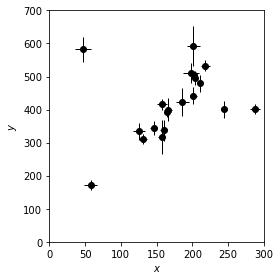

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(x, y, c="k", s=10)
ax.errorbar(x, y,
            xerr=x_err, yerr=y_err, 
            fmt="o", lw=1, c="k")
ax.set_xlim(0, 300)
ax.set_ylim(0, 700)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
fig.tight_layout()

Now we define each of our log probabities:

In [5]:
def ln_prior(theta):
    b, m, ln_lambda = theta
    # p(ln_lambda) ~ U(-10, 10)
    if ln_lambda > 10 or ln_lambda < -10:
        return -np.inf
    return -3/2 * np.log(1 + m**2)

def ln_likelihood(theta, x, y, C):
    b, m, ln_lambda = theta
    
    # projection vector: vector orthogonal to line
    V = np.array([[-m, 1]]).T

    # orthogonal projection matrix
    intrinsic_variance = np.exp(ln_lambda)**2
    Lambda = (intrinsic_variance / (1 + m**2)) * np.array([
        [m**2, -m],
        [-m,    1]
    ])

    Delta = (y - m * x - b)
    Sigma = (V.T @ (C + Lambda) @ V).flatten()

    # Drop constant terms out the front
    return np.sum(-np.log(Sigma) - 0.5 * Delta**2 / Sigma)

def ln_probability(theta, x, y, C):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return lp
    return lp + ln_likelihood(theta, x, y, C)

We now define the covarience matrix, and use the linear algebra solution for our initial guess of m and b:

In [6]:
# covariance matrix:

covs = np.array([[[x_e**2, 0],
                  [0, y_e**2]] for y_e, x_e in zip(y_err, x_err)])


# get linalg solution
Y = np.atleast_2d(y).T

A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err * y_err)

C_inv = np.linalg.inv(C)
G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)

# use ln_lambda = -3 and linalg solution for initialisation
args = (x, y, covs)
initial_theta = np.hstack([X.T[0], -3])

Optimise using L-BFGS-B:

In [7]:
result = op.minimize(lambda *args: -ln_probability(*args), # want to minimise the -ve log probability
                     initial_theta,
                     args=args,
                     method="L-BFGS-B",
                     bounds=[(None, None), (None, None), (-10, 10)])

Sample Posterior using emcee:

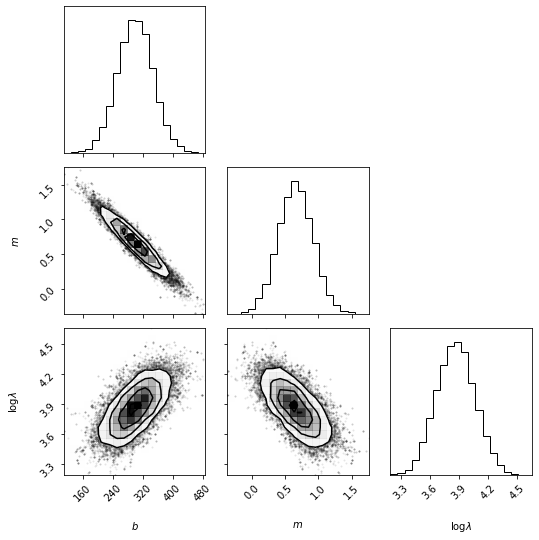

In [8]:
# mcmc sampling
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# burn in
pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

# sample
sampler.run_mcmc(pos, 1000)

# make corner plot
chain = sampler.chain.reshape((-1, ndim))
corner_fig = corner(
    chain,
    labels=(r"$b$", r"$m$", r"$\log{\lambda}$")
)
corner_fig.tight_layout()

Plot posterior predictions:

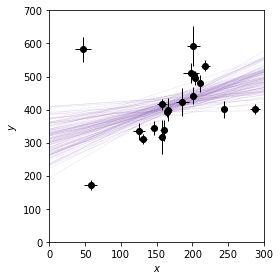

In [9]:
# make posterior predictions
predict_fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(x, y, c="k", s=10)
ax.errorbar(x, y,
            xerr=x_err, yerr=y_err, 
            fmt="o", lw=1, c="k")

xlim = np.array([0, 300])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
# plot draws of the posterior
for index in np.random.choice(chain.shape[0], size=100):
    b, m, ln_lambda = chain[index]
    ax.plot(
        xlim,
        m * xlim + b,
        "-",
        c="tab:purple",
        alpha=0.2,
        lw=0.5,
        zorder=-1
    )

ax.set_xlim(*xlim)
ax.set_ylim(0, 700)

predict_fig.tight_layout()


## Question 6

We will now do the same as Question 5, but with twice the error:

In [10]:
y_err2, x_err2 = 2*y_err, 2*x_err

Our covariance matrix becomes:

In [11]:
covs = np.array([[[x_e**2, 0],
                  [0, y_e**2]] for y_e, x_e in zip(y_err2, x_err2)])


And once again, we get initial conditions given by the linear algebra solution:

In [12]:
# get linalg solution
Y = np.atleast_2d(y).T

A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err2 * y_err2)

C_inv = np.linalg.inv(C)
G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)

# use ln_lambda = -3 and linalg solution for initialisation
args = (x, y, covs)
initial_theta = np.hstack([X.T[0], -3])

Now optimise and run emcee as before:

In [13]:
# optimisation
result = op.minimize(lambda *args: -ln_probability(*args), # want to minimise the -ve log probability
                     initial_theta,
                     args=args,
                     method="L-BFGS-B",
                     bounds=[(None, None), (None, None), (-10, 10)])
# mcmc sampling
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# burn in
pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

# sample
sampler.run_mcmc(pos, 1000)



State([[ 1.57510607e+02  1.42151396e+00  3.48304181e+00]
 [ 2.24915940e+02  1.06655153e+00  3.70035880e+00]
 [ 2.41341410e+02  9.17343036e-01  3.60883192e+00]
 [ 2.19654593e+02  1.06322442e+00  2.84882833e+00]
 [ 2.61318267e+02  8.01310391e-01 -1.23712101e+00]
 [ 2.35227233e+02  9.01927256e-01  2.76013455e+00]
 [ 2.32524125e+02  1.00145282e+00 -7.73206199e+00]
 [ 2.38431254e+02  9.92806973e-01  2.94480505e+00]
 [ 2.44449192e+02  8.88194072e-01  3.12954084e+00]
 [ 2.13919308e+02  1.15936162e+00  2.60634794e+00]
 [ 2.24488838e+02  1.01417613e+00  3.01614907e+00]
 [ 1.85895060e+02  1.28878534e+00  2.67850295e+00]
 [ 2.27882641e+02  9.84144320e-01  3.10383523e+00]
 [ 1.36805270e+02  1.53510706e+00 -1.72176278e+00]
 [ 1.25948038e+02  1.58174411e+00 -8.31225007e+00]
 [ 2.48990291e+02  9.77038620e-01  3.71299600e+00]
 [ 1.90796380e+02  1.16628112e+00  2.54986301e+00]
 [ 2.84434131e+02  7.02074721e-01  3.34285901e+00]
 [ 2.28847842e+02  1.03189953e+00  3.25996152e+00]
 [ 1.73486249e+02  1.3541

Sample Posterior from emcee:

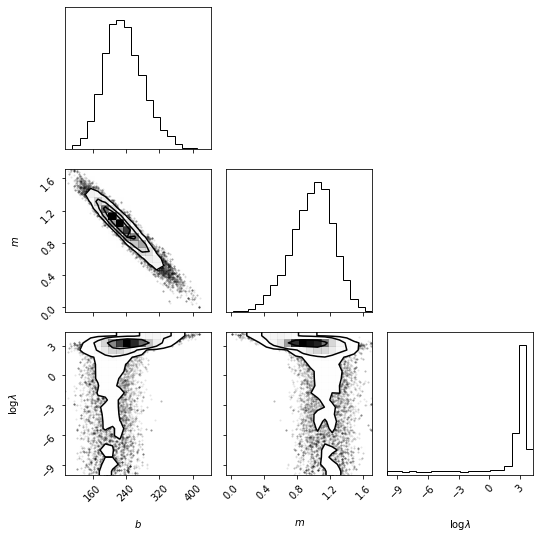

In [14]:
# make corner plot
chain = sampler.chain.reshape((-1, ndim))
corner_fig2 = corner(
    chain,
    labels=(r"$b$", r"$m$", r"$\log{\lambda}$")
)
corner_fig2.tight_layout()

Let's compare to initial posterior:

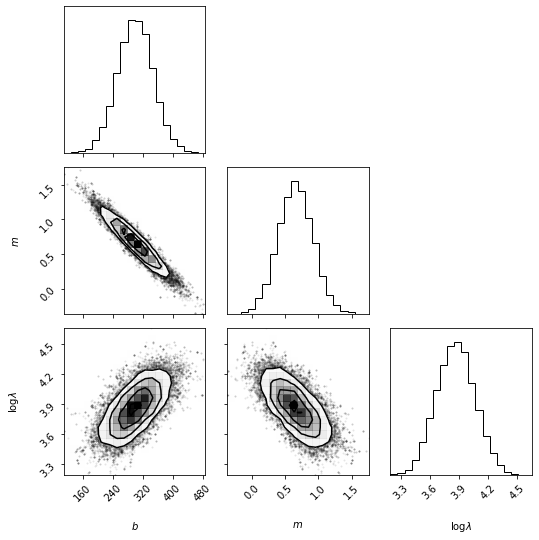

In [15]:
corner_fig

Now Plot posterior predictions:

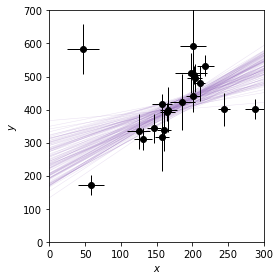

In [19]:
# make posterior predictions
predict_fig2, ax2 = plt.subplots(figsize=(4, 4))
    
ax2.scatter(x, y, c="k", s=10)
ax2.errorbar(x, y,
            xerr=x_err2, yerr=y_err2, 
            fmt="o", lw=1, c="k")

xlim = np.array([0, 300])
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
    
ax2.xaxis.set_major_locator(MaxNLocator(6))
ax2.yaxis.set_major_locator(MaxNLocator(7))
    
# plot draws of the posterior
for index in np.random.choice(chain.shape[0], size=100):
    b, m, ln_lambda = chain[index]
    ax2.plot(
        xlim,
        m * xlim + b,
        "-",
        c="tab:purple",
        alpha=0.2,
        lw=0.5,
        zorder=-1
    )

ax2.set_xlim(*xlim)
ax2.set_ylim(0, 700)

predict_fig2.tight_layout()


Again, compare to the intial case:

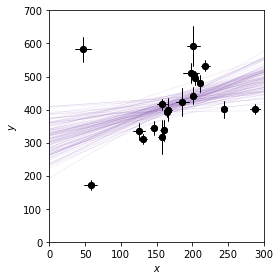

In [20]:
predict_fig

Doubling the errors gives more support to models with a higher intrinsic scatter.

## Question 7

In [31]:
# ranges of each parameter
r_b = np.arange(-500, 500, 1)
r_m = np.arange(-10, 10, 0.2)
r_Q = np.arange(0, 1, .1)
r_mu = np.arange(0, 700, 1)
r_ln_sigma_v = np.arange(-5, 5, 0.1)
r_ln_lambda = np.arange(-10, 10, .1)

# get coords
thetas = np.meshgrid(r_b, r_m, r_Q, r_mu, r_ln_sigma_v, r_ln_lambda, sparse=True)

In [37]:
a = [1, 2, 3, 4]
b = [3, 4, 5, 6]

In [44]:
a, b,  *_ = thetas

In [46]:
b

array([[[[[[-1.00000000e+01]]]]],




       [[[[[-9.80000000e+00]]]]],




       [[[[[-9.60000000e+00]]]]],




       [[[[[-9.40000000e+00]]]]],




       [[[[[-9.20000000e+00]]]]],




       [[[[[-9.00000000e+00]]]]],




       [[[[[-8.80000000e+00]]]]],




       [[[[[-8.60000000e+00]]]]],




       [[[[[-8.40000000e+00]]]]],




       [[[[[-8.20000000e+00]]]]],




       [[[[[-8.00000000e+00]]]]],




       [[[[[-7.80000000e+00]]]]],




       [[[[[-7.60000000e+00]]]]],




       [[[[[-7.40000000e+00]]]]],




       [[[[[-7.20000000e+00]]]]],




       [[[[[-7.00000000e+00]]]]],




       [[[[[-6.80000000e+00]]]]],




       [[[[[-6.60000000e+00]]]]],




       [[[[[-6.40000000e+00]]]]],




       [[[[[-6.20000000e+00]]]]],




       [[[[[-6.00000000e+00]]]]],




       [[[[[-5.80000000e+00]]]]],




       [[[[[-5.60000000e+00]]]]],




       [[[[[-5.40000000e+00]]]]],




       [[[[[-5.20000000e+00]]]]],




       [[[[[-5.00000000e+00]]]]],




       [[[[[

In [32]:
def ln_prior(theta):
    # uniform priors for everything except 
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta
    return -3/2 * np.log(1 + m**2)


# straight line model
def ln_likelihood_fg(theta, x, y, y_err):
    bs, ms, _, _, _, ln_lambdas = theta
    ln_ll_fg = np.zeros(theta.shape)
    
    
    for m in ms:
        for b in bs:
            for ln_lambda in ln_lambdas:
                # Define projection vector.
                V = np.array([[-m, 1]]).T

                # Define orthogonal projection matrix.

                Lambda = (intrinsic_variance / (1 + m**2)) * np.array([
                    [m**2, -m],
                    [-m,    1]
                ])

                Delta = (y - m * x - b)
                Sigma = (V.T @ (C + Lambda) @ V).flatten()

                # Dropping constant terms.
                return np.sum(-np.log(Sigma) - 0.5 * Delta**2 / Sigma)


# And the outlier model as 'background'.
def ln_likelihood_bg(theta, x, y, y_err):
    *_, Q, mu_o, ln_sigma_v, _ = theta
    total_variance = y_err**2 + np.exp(ln_sigma_v)**2
    return -0.5 * ((y - mu_o)**2 / total_variance) - 0.5 * np.log(total_variance)


def ln_probability(theta, x, y, y_err):
    lp = ln_prior(theta)
    
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta
    
    ll_fg = ln_likelihood_fg(theta, x, y, y_err)
    # Compute weighted foreground likelihoods for each data point.
    # (They are weighted by the log(Q) term)
    ll_fg = np.log(Q) + ln_likelihood_fg(theta, x, y, y_err)
    
    # Compute weighted background likelihoods for each data point.
    ll_bg = np.log(1 - Q) + ln_likelihood_bg(theta, x, y, y_err)

    # Sum the log of the sum of the exponents of the log likelihoods.
    ll = np.sum(np.logaddexp(ll_fg, ll_bg))

    return (lp + ll, np.vstack([ll_fg, ll_bg]))
        

## Question 8

In [21]:
Y = np.atleast_2d(y).T

A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err * y_err)

C_inv = np.linalg.inv(C)
G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)

def ln_prior(theta):
    b, m, Q, mu_o, ln_sigma_v = theta
    if not (1 > Q > 0) \
    or not (700 > mu_o > 0) \
    or not (5 > ln_sigma_v > -5):
        return -np.inf
    return -3/2 * np.log(1 + m**2)


# We will describe the straight line model as 'foreground'.
def ln_likelihood_fg(theta, x, y, y_err):
    b, m, *_ = theta
    # Note the extra (constant) term here that we previously have omitted. 
    # Why is it important now?
    return -0.5 * ((y - m * x - b)**2 / y_err**2) - np.log(y_err)


# And the outlier model as 'background'.
def ln_likelihood_bg(theta, x, y, y_err):
    *_, Q, mu_o, ln_sigma_v = theta
    total_variance = y_err**2 + np.exp(ln_sigma_v)**2
    return -0.5 * ((y - mu_o)**2 / total_variance) - 0.5 * np.log(total_variance)


def ln_probability(theta, x, y, y_err):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return (-np.inf, np.nan * np.ones((2, x.size)))
    
    b, m, Q, mu_o, ln_sigma_v = theta
    # Compute weighted foreground likelihoods for each data point.
    # (They are weighted by the log(Q) term)
    ll_fg = np.log(Q) + ln_likelihood_fg(theta, x, y, y_err)
    
    # Compute weighted background likelihoods for each data point.
    ll_bg = np.log(1 - Q) + ln_likelihood_bg(theta, x, y, y_err)

    # Sum the log of the sum of the exponents of the log likelihoods.
    ll = np.sum(np.logaddexp(ll_fg, ll_bg))

    return (lp + ll, np.vstack([ll_fg, ll_bg]))
        

# Optimize!
args = (x, y, y_err)
initial_theta = np.array([250, 1, 0.5, 400, -3])

result = op.minimize(
    lambda *args: -ln_probability(*args)[0],
    initial_theta,
    args=args,
    method="L-BFGS-B",
    bounds=[
        (None, None),
        (None, None),
        (0, 1),
        (0, 700),
        (-5, 5)
    ]
)

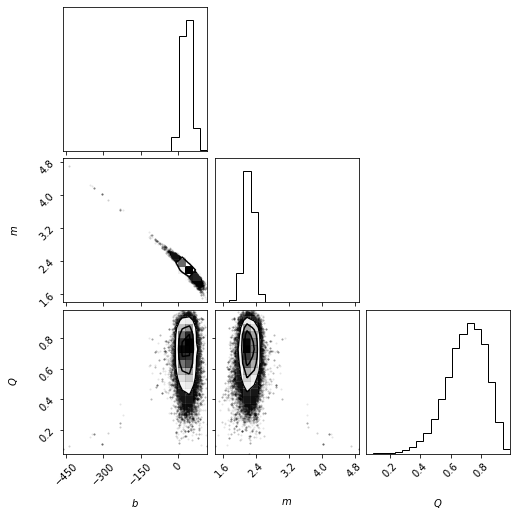

In [22]:
# Sample!
ndim, nwalkers = (result.x.size, 64)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# Run the burn-in.
pos, *_ = sampler.run_mcmc(p0, 1000)
sampler.reset()

# Run production.
sampler.run_mcmc(pos, 2000)

# Make a corner plot just showing m, b, Q
# (the others are nuisance parameters to us)
chain = sampler.chain.reshape((-1, ndim))

fig = corner(
    chain[:, :3],
    labels=(r"$b$", r"$m$", r"$Q$"),
)

